# Stochastic Models and Simulations of Phototaxis
[Link](https://www.researchgate.net/profile/Devaki-Bhaya/publication/265289716_Stochastic_Models_and_Simulations_of_Phototaxis/links/5535445a0cf268fd0015d694/Stochastic-Models-and-Simulations-of-Phototaxis.pdf)

In [1]:
using Random, LinearAlgebra, Plots, Statistics, KernelDensity, StatsPlots

# Functions

In [2]:
"""
Convert polar coordinates to cartesian
"""
polar2cart(r, θ) = r .* [cos(θ) sin(θ)]

"""
Sample N points from a circle of radius R
https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly/50746409

"""
function sampleCircle(N, R)
    # Sample radii
    # PDF = 2x; CDF = x²; CDF⁻¹ = √x
    radii = R * sqrt.(rand(N))
    
    # Sample angles
    # theta = 0 - 2π
    thetas = rand(N) * 2π

    # points
    X = polar2cart.(radii, thetas)
    return X
end


"""Compute all pairwise distances between each point in X
Store in condensed distance matrix form (flattening of upper triangle)

# Inputs
| X: n (observations) x m (dimensions) matrix 
| f(a, b): function to compute distances between a, b
"""
function pairwiseDistance(X, f)
    n = size(X)[1]
    dists = zeros(n, n)
    for i in 1:n
        a = X[i]
        for j in i:n
            b = X[j]
            # Compute distance
            d = f(a, b)
            # Save
            dists[i, j] = dists[j, i] = d
        end
    end
    return dists
end

"""
Compute Euclidean distance between a and b
"""
euclidDist(a, b) = norm(a - b)

"""
Sample n points from a PDF, p
"""
function sampleDiscrete(n, p)
    # Compute cdf (Normalize to sum to 1)
    cdf = cumsum(p) / sum(p)
    # Sample
    choices = [searchsortedfirst(cdf, rand()) for _ in 1:n]
end

"""
Initialize model with N points in a radius R
"""
function initialize(N, R)
    # Initialize points
    X = sampleCircle(N, R)

    # Initialize directions
    θ = rand(N) * 2pi
    # Convert to polar
    θ = polar2cart.(1, θ)

    # Initialize velocities
    v = rand(N) .> .5
    
    return X, v, θ
end

"""
Perform one step of the provided model
"""
function stepModel(model, θ, v, X, p)
    # Select new v and θ
    v, θ = model(θ, v, X, p)

    # Update
    old_X = X
    X += v .* θ

    # Enforce boundary conditions
    outside = norm.(X) .> R
    X[outside] = old_X[outside]
    return X, v, θ
end

stepModel

In [4]:
"""Parameters"""
p = Dict("a"=>.8, "b"=>.5)

p

# Local interactions
At any
given point in time, we assume that every cell may move according to one of the
following three options (shown in Figure 2):
1. a cell may continue to move without changing its previous direction
2.  a cell can stop moving
3. a cell may orient itself. In this case it will moves in the direction of one of its
neighboring cells. The candidate neighboring cells must be within a certain
interaction distance (shown as the dotted circle in Figure 2(c)).

In [7]:
"""
Update step for local interactions model

# Inputs
| θ: Vector of directions (polar coordinates) for each point
| v: Vector of velocities for each point (0 or 1)
| X: Array{Array{Float64, 2}, 1} of points
| p: Dictionary of parameters 
    a: P[not changing direction]
    b: P[not changing velocity]
    D: Radius of interaction
"""
function localInteractionsUpdate(θ, v, X, p)
    N = size(X)[1]
    """Compute pairwise distances"""
    dists = pairwiseDistance(X, euclidDist)
    
    """Get new direction"""
    # Find local interactions for each point
    B = [findall(d .< p["D"]) for d = eachrow(dists)]
    # Count number of non-self elements
    nB = [length(b)-1 for b in B]
    
    # P[same direction] = a; P[swithing to j] = (1-a)/nB
    # i: point in consideration
    # q: each neighbor of i
    PDFs = [[q != i ? ((1 - p["a"]) / nB[i]) : p["a"] for q = B[i]] for i = 1:N]

    # Sample new orientation
    new_dir_idx = reduce(vcat, sampleDiscrete.(1, PDFs))
    # Get corresponding X_idx
    new_X_idx = [B[i][d] for (i, d) in enumerate(new_dir_idx)]
    
    # Get coresponding point
    new_X = X[new_X_idx]
    # Get new direction (X + new_dir = new_X => new_dir = new_X - X)
    new_dir = new_X - X
    new_dir_mag = norm.(new_X - X)
    
    # For points without neighbors, θ stays same, otherwise update direction
    new_θ = [new_dir_mag[i] == 0 ? θ[i] : new_dir[i]/new_dir_mag[i] for i=1:N]

    """Get new velocity"""
    change_v = rand(N) .< p["b"]
    new_v = [change_v[i] ? v[i] : Bool(1-v[i]) for i in 1:N]
    
    return new_v, new_θ
end

localInteractionsUpdate

## Run simulation

In [11]:
@time begin
    # Save nested dictionaries by D then N
    data = Dict()
    R = 250
    
    # Times to run to and save
    tf = 350
    save_ts = [50, 350]
    
    # Parameters to loop over
    Ds = [5, 10]
    Ns = [250, 500]
    for D = Ds
        D_data = Dict()
        for N = Ns
            # Initialize
            X, v, θ = initialize(N, R)
            p["D"] = D
            
            # Run simulation
            Xs = [X]
            t = 1
            
            while t < (tf + 1)
                # Run one step of model
                X, v, θ = stepModel(localInteractionsUpdate, θ, v, X, p)

                # Save X at times of interes
                if t in save_ts
                    push!(Xs, X)
                end
                if t == tf
                    break
                end

                # Recompute pairwise distances
                dists = pairwiseDistance(X, euclidDist)
                t += 1
            end
            # Save simulations for this N
            D_data[N] = Xs
        end
        # Save simulations for this D
        data[D] = D_data
    end
end

 41.139882 seconds (225.25 M allocations: 24.823 GiB, 13.73% gc time)


## Visualize

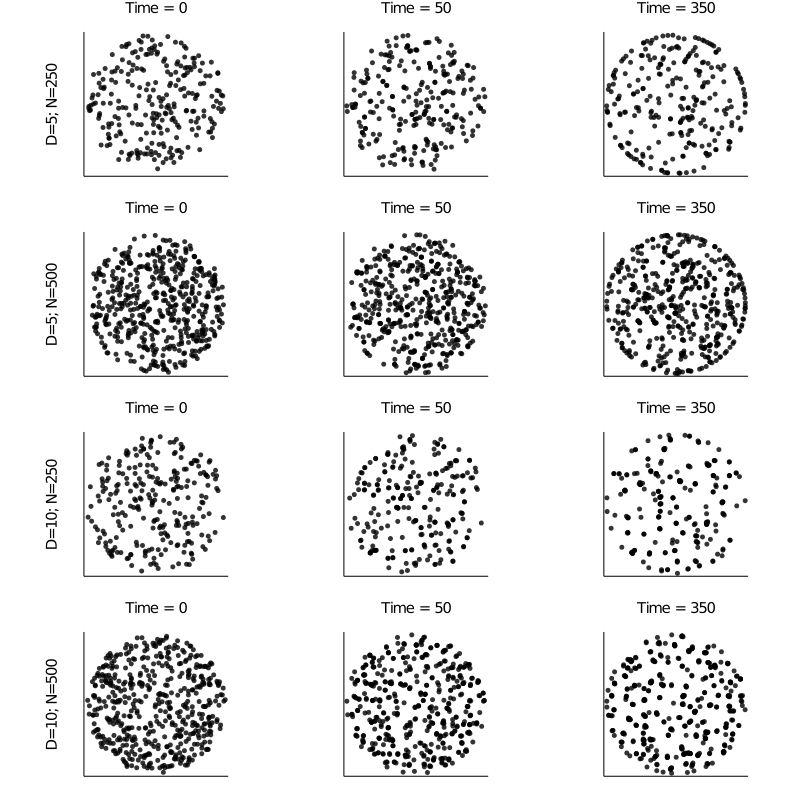

In [33]:
plts = []
for D = Ds
    for N = Ns
        d = data[D][N]
        for (x, t) in zip(d, [0, 50, 350])
            # Convert data to matrix
            Xmat = vcat(x...)
            # Scatter points
            plt = scatter(Xmat[:, 1], Xmat[:, 2], aspect_ratio=:equal, legend=false, markersize=3, alpha=.8, color=:black)
            title!("Time = $t")
            # Add details to left y-axis
            if t == 0
                ylabel!("D=$D; N=$N")
            end
            push!(plts, plt)
        end
    end
end
# Show
lims = (-R-10, R+10)
plt = plot(plts..., titlefontsize=10, yguidefontsize=10, layout=(4, 3), size=(800, 800), xlim=lims, ylims=lims, axis=nothing)
savefig(plt, "results/fig4")
plt